# Tutorial 7: Setup -- Policy Constraints

As show in previous tutorials, the settings file can be changed to adapt to a number of different systems. In Tutorial 3, we discussed how the setting Time Domain Reduction can reduce the computation time of the solver. Other settings, however, directly impact the values of the solution itself. This tutorial goes over the policy attributes in the settings and shows how implementing certain policies affects the optimal solution in GenX. To demonstrate these effects, we will be using `SmallNewEngland/ThreeZones`.

## Table of Contents
* [No Policy Constraints](#NoPolicies)
* [CO$_2$ Cap](#CO2Cap)
    * [Mass Cap](#MassCap)
        * [Tolerance](#Tolerance)
        * [CO$_2$ Slack](#CO2Slack)
    * [Load-based Cap](#LoadCap)
    * [Generator-based Cap](#GenerateCap)
* [Energy Share Requirement](#ESR)
* [Capacity Reserve Margin](#CRM)
* [Minimum Capacity Requriement](#MCR)
* [All Together](#All)
        

## No Policy Constraints <a id="NoPolicies"></a>

In [1]:
using JuMP
using HiGHS
using GenX
using CSV
using DataFrames

In [71]:
case = joinpath("Example_Systems_Tutorials/SmallNewEngland/ThreeZones") 
genx_settings = GenX.get_settings_path(case, "genx_settings.yml");
setup = GenX.configure_settings(genx_settings)

Configuring Settings


Dict{Any, Any} with 24 entries:
  "NetworkExpansion"                        => 1
  "TimeDomainReductionFolder"               => "TDR_Results"
  "EnableJuMPStringNames"                   => false
  "Trans_Loss_Segments"                     => 1
  "ModelingtoGenerateAlternativeSlack"      => 0.1
  "Solver"                                  => "HiGHS"
  "Reserves"                                => 0
  "MultiStage"                              => 0
  "OverwriteResults"                        => 0
  "ModelingToGenerateAlternatives"          => 0
  "MaxCapReq"                               => 0
  "MinCapReq"                               => 1
  "CO2Cap"                                  => 2
  "WriteShadowPrices"                       => 1
  "ModelingToGenerateAlternativeIterations" => 3
  "ParameterScale"                          => 1
  "EnergyShareRequirement"                  => 0
  "PrintModel"                              => 0
  "TimeDomainReduction"                     => 1
  "CapacityRe

The settings we'll focus on here are , `CO2Cap`, `EnergyShareRequirement`, `CapacityReserveMargin`, and `MinCapReq`. Each of these ensures that the environmental impact of the model is taken into account, and are therefore referred to as __policy settings__ . For more information on what each one does, see the <a href="https://genxproject.github.io/GenX/dev/policies/" target="_blank">documentation</a>.

In [3]:
println("MaxCapReq: ", setup["MaxCapReq"])
println("MinCapReq: ", setup["MinCapReq"])
println("CO2Cap: ", setup["CO2Cap"])
println("EnergyShareRequirement: ", setup["EnergyShareRequirement"])
println("CapacityReserveMargin: ", setup["CapacityReserveMargin"])

MaxCapReq: 0
MinCapReq: 1
CO2Cap: 2
EnergyShareRequirement: 0
CapacityReserveMargin: 0


`SmallNewEngland/ThreeZones` uses `MinCapReq` and `CO2Cap`. For the purpose of this tutorial, we're going to set these back to zero to start.

In [72]:
setup["MinCapReq"] = 0
setup["CO2Cap"] = 0;

Now, we'll generate and solve the model using these results:

In [5]:
settings_path = GenX.get_settings_path(case)

## Delte Previous TDR Results
if "TDR_Results" in cd(readdir,case)
    rm(joinpath(case,"TDR_Results"), recursive=true) 
end

### Create TDR_Results
TDRpath = joinpath(case, setup["TimeDomainReductionFolder"])

if setup["TimeDomainReduction"] == 1
    GenX.prevent_doubled_timedomainreduction(case)
    if !GenX.time_domain_reduced_files_exist(TDRpath)
        println("Clustering Time Series Data (Grouped)...")
        GenX.cluster_inputs(case, settings_path, setup)
    else
        println("Time Series Data Already Clustered.")
    end
end

OPTIMIZER =   GenX.configure_solver(settings_path,HiGHS.Optimizer);

inputs = GenX.load_inputs(setup, case)

Clustering Time Series Data (Grouped)...
Reading Input CSV Files
Network.csv Successfully Read!
Load_data.csv Successfully Read!
Fuels_data.csv Successfully Read!
Generators_data.csv Successfully Read!
Generators_variability.csv Successfully Read!
Validating time basis
CSV Files Successfully Read In From Example_Systems_Tutorials/SmallNewEngland/ThreeZones
Reading Input CSV Files
Network.csv Successfully Read!
Load_data.csv Successfully Read!
Fuels_data.csv Successfully Read!
Generators_data.csv Successfully Read!
Generators_variability.csv Successfully Read!
Validating time basis
CSV Files Successfully Read In From Example_Systems_Tutorials/SmallNewEngland/ThreeZones


Dict{Any, Any} with 58 entries:
  "Z"                       => 3
  "LOSS_LINES"              => [1, 2]
  "RET_CAP_CHARGE"          => Int64[]
  "pC_D_Curtail"            => [50.0, 45.0, 27.5, 10.0]
  "dfGen"                   => 10×65 DataFrame…
  "pTrans_Max_Possible"     => [5.9, 4.0]
  "pNet_Map"                => [1.0 -1.0 0.0; 1.0 0.0 -1.0]
  "omega"                   => [5.01374, 5.01374, 5.01374, 5.01374, 5.01374, 5.…
  "pMax_Line_Reinforcement" => [2.95, 2.0]
  "RET_CAP_ENERGY"          => [8, 9, 10]
  "RESOURCES"               => String31["MA_natural_gas_combined_cycle", "MA_so…
  "COMMIT"                  => [1, 3, 6]
  "pMax_D_Curtail"          => [1.0, 0.04, 0.024, 0.003]
  "STOR_ALL"                => [8, 9, 10]
  "THERM_ALL"               => [1, 3, 6]
  "REP_PERIOD"              => 11
  "STOR_LONG_DURATION"      => Int64[]
  "STOR_SYMMETRIC"          => [8, 9, 10]
  "VRE"                     => [2, 4, 5, 7]
  "RETRO"                   => Int64[]
  "THERM_COMMIT"          

In [6]:
EP = GenX.generate_model(setup,inputs,OPTIMIZER)

Discharge Module
Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Emissions Module (for CO2 Policy modularization
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module


A JuMP Model
Minimization problem with:
Variables: 83189
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 24024 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20331 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 103506 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 79492 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: HiGHS
Names registered in the model: cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cTAuxLimit, cTAuxSum, cTLoss, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCNSE, eCStart, eCVar_in, eCVar_out, eELOSS, eELOSSByZone, eEmissionsByPlant, eEmissionsByZone, eExistingCap, eExisting

In [7]:
GenX.solve_model(EP,setup)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
123654 rows, 81159 cols, 433788 nonzeros
116288 rows, 73793 cols, 435120 nonzeros
Presolve : Reductions: rows 116288(-31573); columns 73793(-9396); elements 435120(-74631)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 5544(9846.68); Du: 0(3.97598e-09) 0s
      15621     2.0834389120e+03 Pr: 24131(80721); Du: 0(0.000660903) 5s
      29903     3.5942701870e+03 Pr: 29375(1.86892e+06); Du: 0(0.00171706) 10s
      39776     3.9038148554e+03 Pr: 25317(214460); Du: 0(0.00200947) 15s
      48797     4.2481783152e+03 Pr: 27535(528541); Du: 0(0.002646) 21s
      58433     4.4009644325e+03 Pr: 23884(53779.5); Du: 0(0.00322539) 26s
      71120     4.6137921645e+03 Pr: 18241(11195.6); Du: 0(0.00380196) 31s
      84502     4.6517337319e+03 Pr: 20263(60699); Du: 0(0.0033871) 36s
      98374     4.6798975

(A JuMP Model
Minimization problem with:
Variables: 83189
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 24024 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20331 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 103506 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 79492 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cTAuxLimit, cTAuxSum, cTLoss, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCNSE, eCStart, eCVar_in, eCVar_out, eELOSS, eELOSSByZone, eEmissionsByPlant, eEmissionsByZone, eExistingCap, eExis

Using `value.()`, we can see what the total capacity is of the optimized model:

In [8]:
totCap_base = value.(EP[:eTotalCap])

10-element Vector{Float64}:
 13.11398854195083
  0.0
 10.196730225767793
  0.0
  0.0
  0.047957415124481456
  0.8862282518623694
  0.0
  0.0
  0.0

Each element corresponds to the MW value of the node in the grid. In `ThreeZones`, there are ten nodes, each of which are either natural gas, wind, solar, or battery plants. We can see which is which using `Resource_Type`:

In [9]:
RT = inputs["dfGen"][:,:Resource_Type];
DataFrame([RT totCap_base],["Resource Type","Total Capacity"])

Row,Resource Type,Total Capacity
,Any,Any
1,natural_gas_fired_combined_cycle,13.114
2,solar_photovoltaic,0.0
3,natural_gas_fired_combined_cycle,10.1967
4,onshore_wind_turbine,0.0
5,solar_photovoltaic,0.0
6,natural_gas_fired_combined_cycle,0.0479574
7,onshore_wind_turbine,0.886228
8,battery_mid,0.0
9,battery_mid,0.0


To visualize the impact of the emmissions policies, let's group the nodes together by type and plot the data.

In [10]:
using Plots
using StatsPlots

In [11]:
# Group by plant type
totCapB = [totCap_base[1] + totCap_base[3] + totCap_base[6], totCap_base[2] + totCap_base[5], 
    totCap_base[4] + totCap_base[7], totCap_base[8] + totCap_base[9] + totCap_base[10]]
totCapB = reshape(totCapB,(:,1)) # Convert to matrix

4×1 Matrix{Float64}:
 23.358676182843105
  0.0
  0.8862282518623694
  0.0

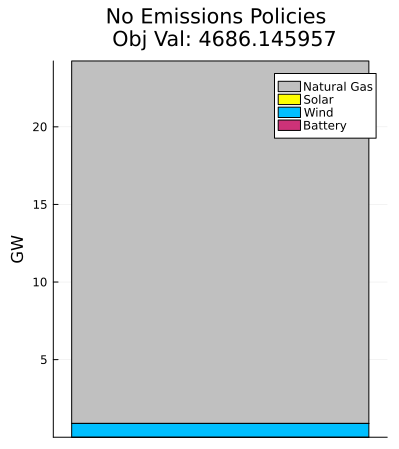

In [12]:
colors=[:silver :yellow :deepskyblue :violetred3]

G1 = groupedbar(transpose(totCapB), bar_position = :stack, bar_width=0.1,size=(400,450),
    labels=["Natural Gas" "Solar" "Wind" "Battery"],
    title="No Emissions Policies \n Obj Val: $(round(objective_value(EP),digits=6))",xticks=[ ],ylabel="GW",color=colors)

As you can see, with no limit on emissions, GenX goes straight to using natural gas. Let's try changing the settings to enforce emissions constraints.

## CO2 Cap <a id="CO2Cap"></a>

The setting <a href="https://genxproject.github.io/GenX/dev/policies/#CO_2-Constraint-Policy" target="_blank">`CO2Cap`</a> 
specifies if the model should have a constraint on CO$_2$ emmissions, and, if so, what that constraint should look like. There are three types, mass, load-based, and generator-based.

### Mass Cap <a id="MassCap"></a>

The first type of constraint, done by setting `CO2Cap` to "1", is a mass based constraint, which simply puts a limit on the total tons of CO$_2$ able to be produced per megawatt of electricty.

In [13]:
setup["CO2Cap"] = 1;

1

In [14]:
inputs = GenX.load_inputs(setup, case)
EP2 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP2,setup)

Reading Input CSV Files
Network.csv Successfully Read!
Load_data.csv Successfully Read!
Fuels_data.csv Successfully Read!
Generators_data.csv Successfully Read!
Generators_variability.csv Successfully Read!
Validating time basis
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From Example_Systems_Tutorials/SmallNewEngland/ThreeZones
Discharge Module
Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Emissions Module (for CO2 Policy modularization
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
C02 Policies Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
123657 rows, 81159 cols, 444876 nonzeros
116559 rows, 74061 cols, 445158 nonzeros
Presolve : Reductions: rows 116559(-31305); columns 74061(-9131); elements 445158

(A JuMP Model
Minimization problem with:
Variables: 83192
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 24024 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20331 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 103509 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 4 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 79492 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: cCO2Emissions_systemwide, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cTAuxLimit, cTAuxSum, cTLoss, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCNSE, eCStart, eCVar_in, eCVar_out, eELOSS, eELOSSByZone, eEmissionsByPlant, eEmissions

In [15]:
totCap2 = value.(EP2[:eTotalCap])
totCapB2 = [totCap2[1] + totCap2[3] + totCap2[6], totCap2[2] + totCap2[5], 
    totCap2[4] + totCap2[7], totCap2[8] + totCap2[9] + totCap2[10]]

DataFrame([RT totCap2],["Resource Type","Total Capacity"])

Row,Resource Type,Total Capacity
,Any,Any
1,natural_gas_fired_combined_cycle,1.13071
2,solar_photovoltaic,42.6697
3,natural_gas_fired_combined_cycle,1.04912
4,onshore_wind_turbine,2.21081
5,solar_photovoltaic,67.0745
6,natural_gas_fired_combined_cycle,0.668954
7,onshore_wind_turbine,6.8699
8,battery_mid,11.1238
9,battery_mid,27.7801


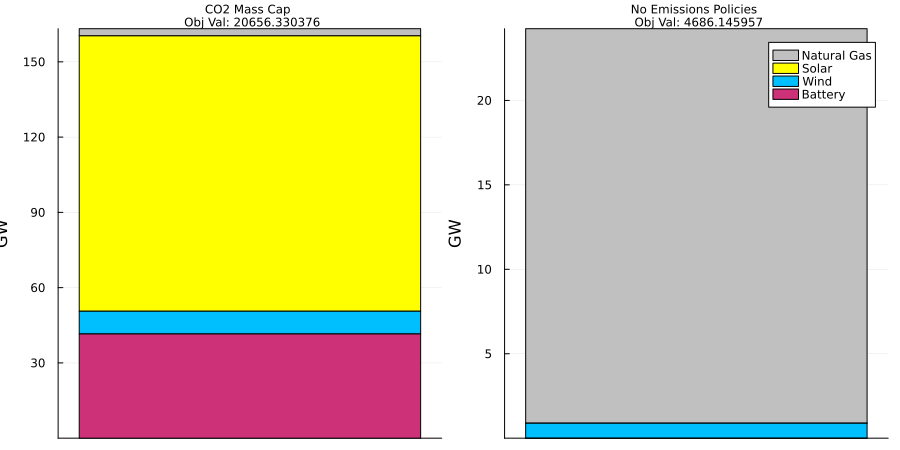

In [16]:
G2 = groupedbar(transpose(totCapB2), bar_position = :stack, bar_width=0.1,size=(100,450),
    labels=["Natural Gas" "Solar" "Wind" "Battery"],legend = false,title="CO2 Mass Cap \n Obj Val: $(round(objective_value(EP2),digits=6))",
xticks=[ ],ylabel="GW",color=colors)
plot(G2,G1,size=(900,450),titlefontsize=8)


The model favors solar power now, but natural gas and wind are also used. One thing to note is that the objective value of this system is much higher than it was without emissions constraints. The amount of CO$_2$ allowed is determined by the inputfile CO2_cap.csv:

In [65]:
CO2Cap =  CSV.read(joinpath(case,"CO2_cap.csv"),DataFrame,missingstring="NA")

Row,Column1,Network_zones,CO_2_Cap_Zone_1,CO_2_Cap_Zone_2,CO_2_Cap_Zone_3,CO_2_Max_tons_MWh_1,CO_2_Max_tons_MWh_2,CO_2_Max_tons_MWh_3,CO_2_Max_Mtons_1,CO_2_Max_Mtons_2,CO_2_Max_Mtons_3
,String3,String3,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,MA,z1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,CT,z2,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0
3,ME,z3,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0


#### Tolerance of Cap <a id="Tolerance"></a>

Let's try setting the CO$_2$ emissions tolerance to 0 for all nodes:

In [18]:
CO2Cap2 = CO2Cap; # Save old tolerances
CSV.write(joinpath(case,"CO2_cap_old.csv"),CO2Cap)

In [19]:
CO2Cap2[!,"CO_2_Max_tons_MWh_1"] = [0.0;0.0;0.0];
CO2Cap2[!,"CO_2_Max_tons_MWh_2"] = [0.0;0.0;0.0];
CO2Cap2[!,"CO_2_Max_tons_MWh_3"] = [0.0;0.0;0.0];
CO2Cap2[!,"CO_2_Max_Mtons_1"] = [0.0;0.0;0.0];
CO2Cap2[!,"CO_2_Max_Mtons_2"] = [0.0;0.0;0.0];
CO2Cap2[!,"CO_2_Max_Mtons_3"] = [0.0;0.0;0.0];

In [20]:
CSV.write(joinpath(case,"CO2_cap.csv"),CO2Cap2)

"Example_Systems_Tutorials/SmallNewEngland/ThreeZones/CO2_cap.csv"

In [21]:
inputs = GenX.load_inputs(setup, case)
EP3 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP3,setup)

Reading Input CSV Files
Network.csv Successfully Read!
Load_data.csv Successfully Read!
Fuels_data.csv Successfully Read!
Generators_data.csv Successfully Read!
Generators_variability.csv Successfully Read!
Validating time basis
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From Example_Systems_Tutorials/SmallNewEngland/ThreeZones
Discharge Module
Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Emissions Module (for CO2 Policy modularization
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
C02 Policies Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
68214 rows, 58980 cols, 217572 nonzeros
61245 rows, 52011 cols, 217338 nonzeros
Presolve : Reductions: rows 61245(-86619); columns 52011(-31181); elements 217338(-

(A JuMP Model
Minimization problem with:
Variables: 83192
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 24024 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20331 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 103509 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 4 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 79492 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: cCO2Emissions_systemwide, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cTAuxLimit, cTAuxSum, cTLoss, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCNSE, eCStart, eCVar_in, eCVar_out, eELOSS, eELOSSByZone, eEmissionsByPlant, eEmissions

10×2 DataFrame
 Row │ Resource Type                     Total Capacity 
     │ Any                               Any            
─────┼──────────────────────────────────────────────────
   1 │ natural_gas_fired_combined_cycle  0.0
   2 │ solar_photovoltaic                43.5155
   3 │ natural_gas_fired_combined_cycle  0.0
   4 │ onshore_wind_turbine              0.0
   5 │ solar_photovoltaic                69.9142
   6 │ natural_gas_fired_combined_cycle  0.0
   7 │ onshore_wind_turbine              5.72412
   8 │ battery_mid                       14.7508
   9 │ battery_mid                       31.4321
  10 │ battery_mid                       2.60781
 
Objective Value: 23674.943245171446


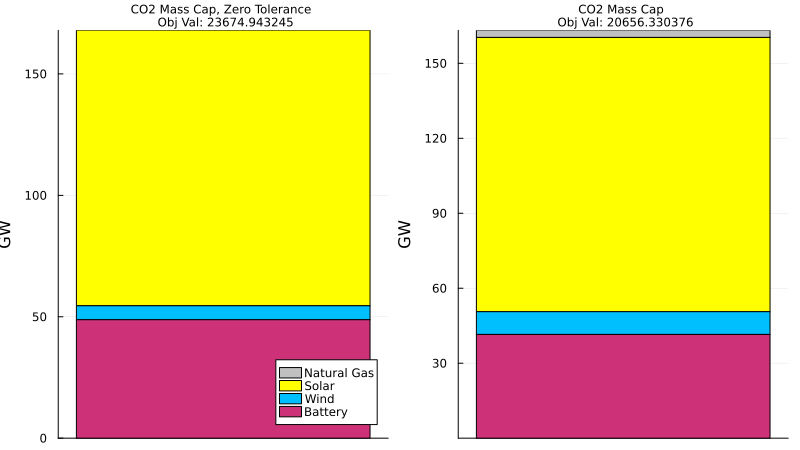

In [32]:
totCap3 = value.(EP3[:eTotalCap])

totCapB3 = [totCap3[1] + totCap3[3] + totCap3[6], totCap3[2] + totCap3[5], 
    totCap3[4] + totCap3[7], totCap3[8] + totCap3[9] + totCap3[10]]

println(DataFrame([RT totCap3],["Resource Type","Total Capacity"]))
println(" ")

println("Objective Value: ", objective_value(EP3))

G3 = groupedbar(transpose(totCapB3), bar_position = :stack, bar_width=0.1,size=(400,450), xticks=[ ],ylabel="GW",
    labels=["Natural Gas" "Solar" "Wind" "Battery"],color=colors,
    title="CO2 Mass Cap, Zero Tolerance \n Obj Val: $(round(objective_value(EP3),digits=6))")

plot(G3,G2,size=(800,450),titlefontsize=8)

As you can see, the use of natural gas has been eliminated compeltely. Note that the objective value increases here as well as renewable energy tends to cost more than natural gas.

#### CO$_2$ Slack Cap <a id="CO2Slack"></a>

Another thing we can do is, instead of demanding that the model 100% meet the CO$_2$ cap, we can add a penalty for if it violates the cap. This lets the system allow some CO$_2$ emmissions if it's determined the cost of the grid with some emmissions is low enough that it will offset the cost from the penalty variable. GenX will automatically incorporate this feature if a file by the name "CO2_cap_slack.csv" is in the directory. For more information on other types of policy slack variables in GenX, see the <a href="https://genxproject.github.io/GenX/dev/slack_variables_overview/#Policy-Slack-Variables" target="_blank">documentation</a>.

In [23]:
CO2Cap_slack = DataFrame(["CO_2_Cap_Zone_1" 9999; "CO_2_Cap_Zone_2" 9999; "CO_2_Cap_Zone_2" 9999],["CO2_Cap_Constraint","PriceCap"])

Row,CO2_Cap_Constraint,PriceCap
,Any,Any
1,CO_2_Cap_Zone_1,9999
2,CO_2_Cap_Zone_2,9999
3,CO_2_Cap_Zone_2,9999


In [24]:
CSV.write(joinpath(case,"CO2_cap_slack.csv"),CO2Cap_slack)

"Example_Systems_Tutorials/SmallNewEngland/ThreeZones/CO2_cap_slack.csv"

And run it again,

In [25]:
inputs = GenX.load_inputs(setup, case)
EP4 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP4,setup)

Reading Input CSV Files
Network.csv Successfully Read!
Load_data.csv Successfully Read!
Fuels_data.csv Successfully Read!
Generators_data.csv Successfully Read!
Generators_variability.csv Successfully Read!
Validating time basis
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From Example_Systems_Tutorials/SmallNewEngland/ThreeZones
Discharge Module
Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Emissions Module (for CO2 Policy modularization
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
C02 Policies Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
123654 rows, 81159 cols, 433788 nonzeros
116288 rows, 73793 cols, 435120 nonzeros
Presolve : Reductions: rows 116288(-31576); columns 73793(-9399); elements 435120

(A JuMP Model
Minimization problem with:
Variables: 83192
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 24024 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20331 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 103509 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 79495 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: cCO2Emissions_systemwide, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cTAuxLimit, cTAuxSum, cTLoss, eAvail_Trans_Cap, eCCO2Cap_slack, eCFix, eCFixEnergy, eCNSE, eCStart, eCTotalCO2CapSlack, eCVar_in, eCVar_out, eELOSS, eELOSSBy

In [40]:
value.(EP4[:eCTotalCO2CapSlack])

2358.4383716403095

10×2 DataFrame
 Row │ Resource Type                     Total Capacity 
     │ Any                               Any            
─────┼──────────────────────────────────────────────────
   1 │ natural_gas_fired_combined_cycle  1.43087
   2 │ solar_photovoltaic                60.2212
   3 │ natural_gas_fired_combined_cycle  3.23176
   4 │ onshore_wind_turbine              4.37615
   5 │ solar_photovoltaic                34.3779
   6 │ natural_gas_fired_combined_cycle  0.0
   7 │ onshore_wind_turbine              6.8699
   8 │ battery_mid                       19.4604
   9 │ battery_mid                       13.0214
  10 │ battery_mid                       2.70268
 
Objective Value: 20471.6182357393


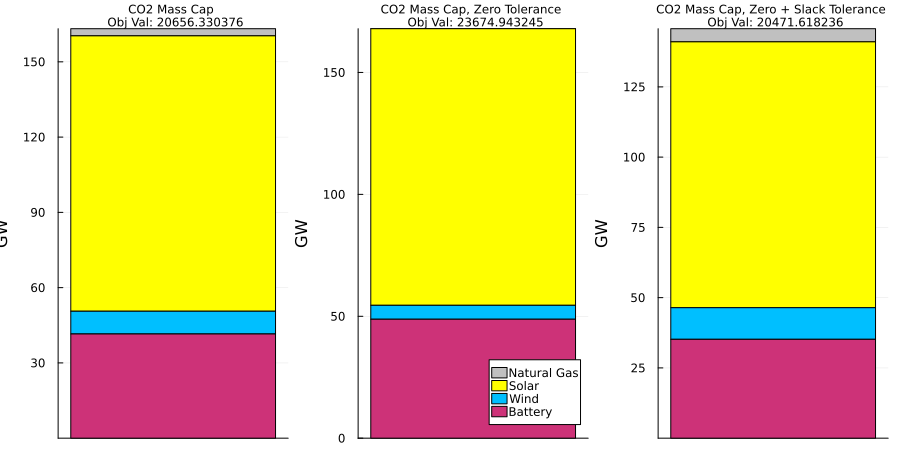

In [26]:
totCap4 = value.(EP4[:eTotalCap])

totCapB4 = [totCap4[1] + totCap4[3] + totCap4[6], totCap4[2] + totCap4[5], 
    totCap4[4] + totCap4[7], totCap4[8] + totCap4[9] + totCap4[10]]

println(DataFrame([RT totCap4],["Resource Type","Total Capacity"]))
println(" ")

println("Objective Value: ", objective_value(EP4))

G4 = groupedbar(transpose(totCapB4), bar_position = :stack, bar_width=0.1,size=(400,450), xticks=[ ],ylabel="GW",
    labels=["Natural Gas" "Solar" "Wind" "Battery"],legend=false,color=colors,
    title="CO2 Mass Cap, Zero + Slack Tolerance \n Obj Val: $(round(objective_value(EP4),digits=6))")

plot(G2,G3,G4,size=(900,450),layout=(1,3),titlefontsize=8)

Adding in the slack variables allowed for some natural gas to be used once again and decreased the overall cost (objective function).

###  Load + Rate-Based CO$_2$ Cap <a id="LoadCap"></a>

Another way to set the CO$_2$ emissions cap is to limit emissions as a function of the total demand in that region. This can be done by setting `CO2Cap` to "2" in the setup:

In [27]:
setup["CO2Cap"] = 2;

2

Let's set the CO2_cap.csv back to it's original data, and remove the slack cap:

In [28]:
rm(joinpath(case,"CO2_cap_slack.csv"))
CSV.write(joinpath(case,"CO2_cap.csv"),CO2Cap)

"Example_Systems_Tutorials/SmallNewEngland/ThreeZones/CO2_cap.csv"

In [29]:
inputs = GenX.load_inputs(setup, case)
EP5 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP5,setup)

Reading Input CSV Files
Network.csv Successfully Read!
Load_data.csv Successfully Read!
Fuels_data.csv Successfully Read!
Generators_data.csv Successfully Read!
Generators_variability.csv Successfully Read!
Validating time basis
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From Example_Systems_Tutorials/SmallNewEngland/ThreeZones
Discharge Module
Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Emissions Module (for CO2 Policy modularization
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
C02 Policies Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
68214 rows, 58980 cols, 217572 nonzeros
61245 rows, 52011 cols, 217338 nonzeros
Presolve : Reductions: rows 61245(-86619); columns 52011(-31181); elements 217338(-

(A JuMP Model
Minimization problem with:
Variables: 83192
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 24024 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20331 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 103509 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 4 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 79492 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: cCO2Emissions_systemwide, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cTAuxLimit, cTAuxSum, cTLoss, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCNSE, eCStart, eCVar_in, eCVar_out, eELOSS, eELOSSByZone, eEmissionsByPlant, eEmissions

10×2 DataFrame
 Row │ Resource Type                     Total Capacity 
     │ Any                               Any            
─────┼──────────────────────────────────────────────────
   1 │ natural_gas_fired_combined_cycle  0.0
   2 │ solar_photovoltaic                43.5155
   3 │ natural_gas_fired_combined_cycle  0.0
   4 │ onshore_wind_turbine              0.0
   5 │ solar_photovoltaic                69.9142
   6 │ natural_gas_fired_combined_cycle  0.0
   7 │ onshore_wind_turbine              5.72412
   8 │ battery_mid                       14.7508
   9 │ battery_mid                       31.4321
  10 │ battery_mid                       2.60781
 


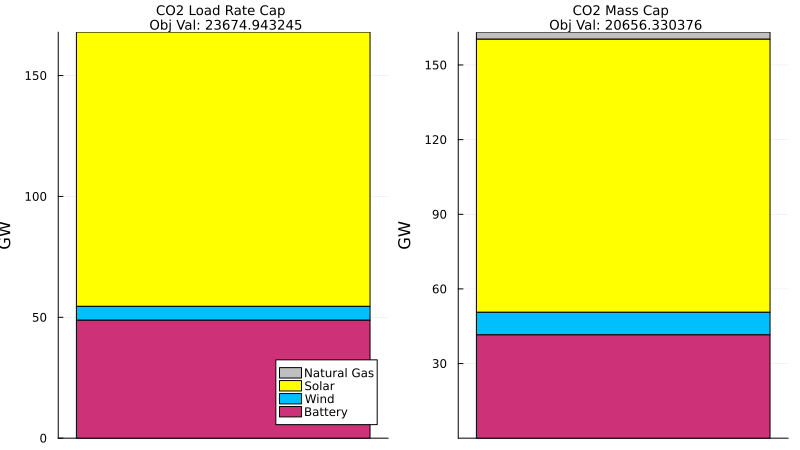

In [31]:
totCap5 = value.(EP5[:eTotalCap])

totCapB5 = [totCap5[1] + totCap5[3] + totCap5[6], totCap5[2] + totCap5[5], 
    totCap5[4] + totCap5[7], totCap5[8] + totCap5[9] + totCap5[10]]

toPlot = [transpose(totCapB2);transpose(totCapB5)]

println(DataFrame([RT totCap5],["Resource Type","Total Capacity"]))
println(" ")

G5 = groupedbar(transpose(totCapB5), bar_position = :stack, bar_width=.8,size=(500,450), xticks=[ ],ylabel="GW",
        labels=["Natural Gas" "Solar" "Wind" "Battery"],color=colors,
        title="CO2 Load Rate Cap \n Obj Val: $(round(objective_value(EP5),digits=6))")
plot(G5,G2,size=(800,450), titlefontsize=9)

### Generation + Rate-based CO$_2$ Cap <a id="GenerateCap"></a>

Finally, the third type of emissions cap in GenX is where the constraint is based on the ratio between the CO$_2$ cap and the generation of each node.

In [33]:
setup["CO2Cap"] = 3;

3

In [34]:
inputs = GenX.load_inputs(setup, case)
EP6 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP6,setup)

Reading Input CSV Files
Network.csv Successfully Read!
Load_data.csv Successfully Read!
Fuels_data.csv Successfully Read!
Generators_data.csv Successfully Read!
Generators_variability.csv Successfully Read!
Validating time basis
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From Example_Systems_Tutorials/SmallNewEngland/ThreeZones
Discharge Module
Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Emissions Module (for CO2 Policy modularization
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
C02 Policies Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
68214 rows, 58980 cols, 217572 nonzeros
61245 rows, 52011 cols, 217338 nonzeros
Presolve : Reductions: rows 61245(-86619); columns 52011(-31181); elements 217338(-

(A JuMP Model
Minimization problem with:
Variables: 83192
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 24024 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20331 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 103509 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 4 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 79492 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: cCO2Emissions_systemwide, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cTAuxLimit, cTAuxSum, cTLoss, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCNSE, eCStart, eCVar_in, eCVar_out, eELOSS, eELOSSByZone, eEmissionsByPlant, eEmissions

10×2 DataFrame
 Row │ Resource Type                     Total Capacity 
     │ Any                               Any            
─────┼──────────────────────────────────────────────────
   1 │ natural_gas_fired_combined_cycle  0.0
   2 │ solar_photovoltaic                43.5155
   3 │ natural_gas_fired_combined_cycle  0.0
   4 │ onshore_wind_turbine              0.0
   5 │ solar_photovoltaic                69.9142
   6 │ natural_gas_fired_combined_cycle  0.0
   7 │ onshore_wind_turbine              5.72412
   8 │ battery_mid                       14.7508
   9 │ battery_mid                       31.4321
  10 │ battery_mid                       2.60781
 


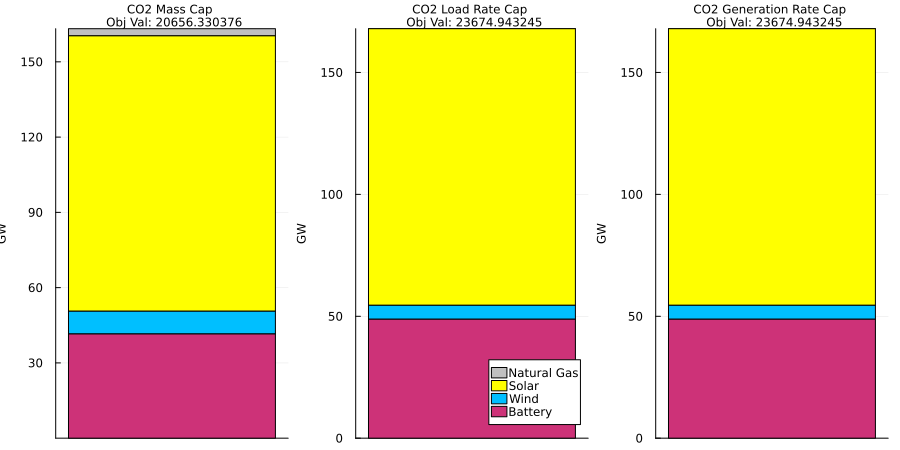

In [35]:
totCap6 = value.(EP6[:eTotalCap])

totCapB6 = [totCap6[1] + totCap6[3] + totCap6[6], totCap6[2] + totCap6[5], 
    totCap6[4] + totCap6[7], totCap6[8] + totCap6[9] + totCap6[10]]

println(DataFrame([RT totCap6],["Resource Type","Total Capacity"]))
println(" ")

G6 = groupedbar(transpose(totCapB6), bar_position = :stack, bar_width=.7,size=(500,450), xticks=[ ],ylabel="GW",
        labels=["Natural Gas" "Solar" "Wind" "Battery"],legend=false,color=colors,
        title="CO2 Generation Rate Cap \n Obj Val: $(round(objective_value(EP6),digits=6))",ylabelfontsize=8)
plot(G2,G5,G6,size=(900,450), titlefontsize=8,layout=(1,3),)

## Energy Share Requirement <a id="ESR"></a>

Many countries have policies that demand a certain percentage of energy provided to consumers comes from renewable energy (in the US, these are called <a href="https://www.eia.gov/energyexplained/renewable-sources/portfolio-standards.php#:~:text=Renewable%20portfolio%20standards%20(RPS)%2C,energy%20sources%20for%20electricity%20generation" target="_blank">renewable portfolio standards</a>.) In GenX, this policy can be implemented by setting `EnergyShareRequirement` to 1 in the setup.

In [68]:
ESR =  CSV.read(joinpath(case,"Energy_share_requirement.csv"),DataFrame,missingstring="NA")

Row,Column1,Network_zones,ESR_1,ESR_2
,String3,String3,Float64,Float64
1,MA,z1,0.259,0.348
2,CT,z2,0.44,0.44
3,ME,z3,0.776,0.776


In [36]:
setup["CO2Cap"] = 0 # set back to 0 to compare
setup["EnergyShareRequirement"] = 1;

In [37]:
inputs = GenX.load_inputs(setup, case)
EP7 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP7,setup)

Reading Input CSV Files
Network.csv Successfully Read!
Load_data.csv Successfully Read!
Fuels_data.csv Successfully Read!
Generators_data.csv Successfully Read!
Generators_variability.csv Successfully Read!
Validating time basis
Energy_share_requirement.csv Successfully Read!
CSV Files Successfully Read In From Example_Systems_Tutorials/SmallNewEngland/ThreeZones
Discharge Module
Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Emissions Module (for CO2 Policy modularization
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
Energy Share Requirement Policies Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
123656 rows, 81159 cols, 444540 nonzeros
116289 rows, 73793 cols, 440496 nonzeros
Presolve : Reductions: rows 116289(-31574);

(A JuMP Model
Minimization problem with:
Variables: 83189
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 24024 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20333 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 103506 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 79492 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: cESRShare, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cTAuxLimit, cTAuxSum, cTLoss, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCNSE, eCStart, eCVar_in, eCVar_out, eELOSS, eELOSSByZone, eESR, eESRDischarge, eEmissionsByPlant, eEmis

10×2 DataFrame
 Row │ Resource Type                     Total Capacity 
     │ Any                               Any            
─────┼──────────────────────────────────────────────────
   1 │ natural_gas_fired_combined_cycle  10.9956
   2 │ solar_photovoltaic                0.245678
   3 │ natural_gas_fired_combined_cycle  7.51978
   4 │ onshore_wind_turbine              6.7
   5 │ solar_photovoltaic                0.0
   6 │ natural_gas_fired_combined_cycle  0.0
   7 │ onshore_wind_turbine              6.76363
   8 │ battery_mid                       0.482563
   9 │ battery_mid                       0.218857
  10 │ battery_mid                       0.704838
 


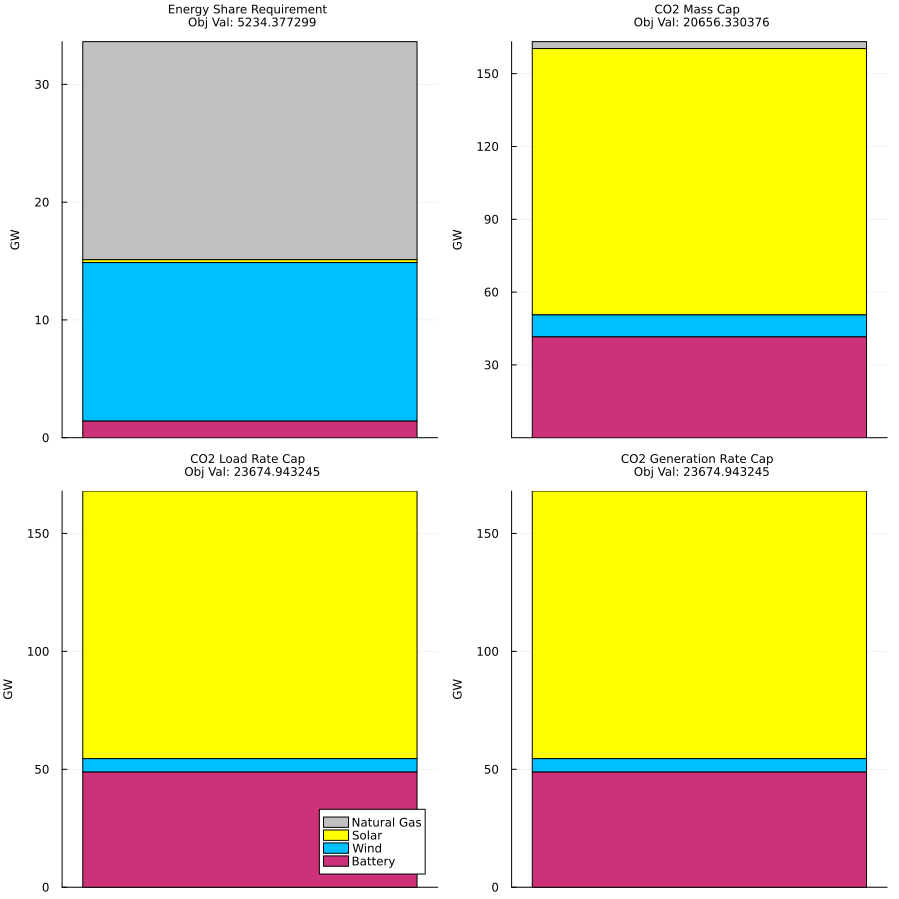

In [39]:
totCap7 = value.(EP7[:eTotalCap])

totCapB7 = [totCap7[1] + totCap7[3] + totCap7[6], totCap7[2] + totCap7[5], 
    totCap7[4] + totCap7[7], totCap7[8] + totCap7[9] + totCap7[10]]

println(DataFrame([RT totCap7],["Resource Type","Total Capacity"]))
println(" ")

G7 = groupedbar(transpose(totCapB7), bar_position = :stack, bar_width=.7,size=(500,450), xticks=[ ],ylabel="GW",
        labels=["Natural Gas" "Solar" "Wind" "Battery"],legend=false,color=colors,
        title="Energy Share Requirement \n Obj Val: $(round(objective_value(EP7),digits=6))",ylabelfontsize=8)
plot(G7,G2,G5,G6,size=(900,900), titlefontsize=8,layout=(2,2))

The Energy Share Requriement policy also has the possibiliy to be run with <a href="https://genxproject.github.io/GenX/dev/slack_variables_overview/#Policy-Slack-Variables" target="_blank">slack variables</a>.

## Capacity Reserve Margin <a id="CRM"></a>

The  <a href="https://genxproject.github.io/GenX/dev/policies/#Capacity-Reserve-Margin" target="_blank">Capacity Reserve Margin</a> constraint demands that a certain amount of energy always be available in each zone, expressed as a fraction of the demand. .

In [41]:
CapacityReserve =  CSV.read(joinpath(case,"Capacity_reserve_margin.csv"),DataFrame,missingstring="NA")

Row,Column1,Network_zones,CapRes_1
,String3,String3,Float64
1,MA,z1,0.156
2,CT,z2,0.156
3,ME,z3,0.156


In [46]:
setup["CapacityReserveMargin"] = 1;

In [47]:
inputs = GenX.load_inputs(setup, case)
EP8 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP8,setup)

Reading Input CSV Files
Network.csv Successfully Read!
Load_data.csv Successfully Read!
Fuels_data.csv Successfully Read!
Generators_data.csv Successfully Read!
Generators_variability.csv Successfully Read!
Validating time basis
Capacity_reserve_margin.csv Successfully Read!
Energy_share_requirement.csv Successfully Read!
CSV Files Successfully Read In From Example_Systems_Tutorials/SmallNewEngland/ThreeZones
Discharge Module
Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Emissions Module (for CO2 Policy modularization
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
Energy Share Requirement Policies Module
Capacity Reserve Margin Policies Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
125504 rows, 81159 cols, 483180 nonzer

(A JuMP Model
Minimization problem with:
Variables: 83189
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 24024 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 22181 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 103506 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 79492 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: cCapacityResMargin, cESRShare, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cTAuxLimit, cTAuxSum, cTLoss, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCNSE, eCStart, eCVar_in, eCVar_out, eCapResMarBalance, eCapResMarBalanceNSE, eCapRe

10×2 DataFrame
 Row │ Resource Type                     Total Capacity 
     │ Any                               Any            
─────┼──────────────────────────────────────────────────
   1 │ natural_gas_fired_combined_cycle  11.6905
   2 │ solar_photovoltaic                0.487683
   3 │ natural_gas_fired_combined_cycle  12.4679
   4 │ onshore_wind_turbine              6.6956
   5 │ solar_photovoltaic                0.0
   6 │ natural_gas_fired_combined_cycle  0.0
   7 │ onshore_wind_turbine              6.73231
   8 │ battery_mid                       0.544018
   9 │ battery_mid                       0.0
  10 │ battery_mid                       0.557277
 


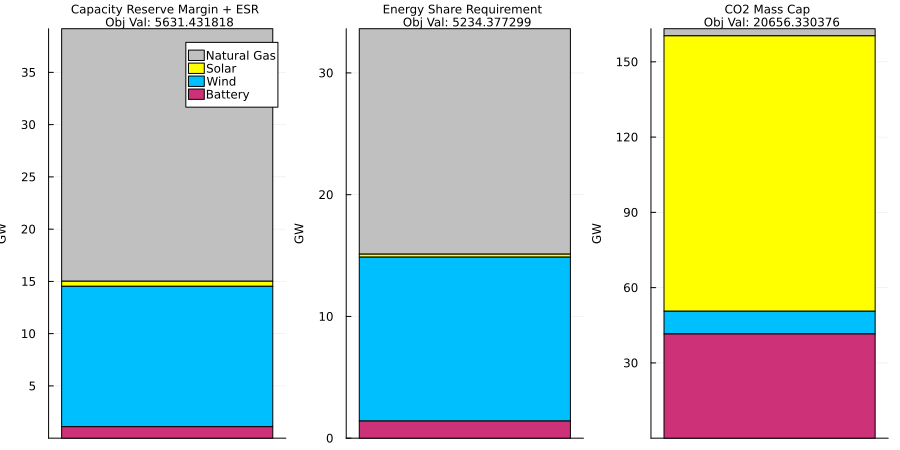

In [58]:
totCap8 = value.(EP8[:eTotalCap])

totCapB8 = [totCap8[1] + totCap8[3] + totCap8[6], totCap8[2] + totCap8[5], 
    totCap8[4] + totCap8[7], totCap8[8] + totCap8[9] + totCap8[10]]

println(DataFrame([RT totCap8],["Resource Type","Total Capacity"]))
println(" ")

G8 = groupedbar(transpose(totCapB8), bar_position = :stack, bar_width=.7,size=(500,450), xticks=[ ],ylabel="GW",
        labels=["Natural Gas" "Solar" "Wind" "Battery"],color=colors,
        title="Capacity Reserve Margin + ESR \n Obj Val: $(round(objective_value(EP8),digits=6))",ylabelfontsize=8)

plot(G8,G7,G2,size=(900,450), titlefontsize=8,layout=(1,3))

Capacity Reserve Margin also has the possibiliy to be run with <a href="https://genxproject.github.io/GenX/dev/slack_variables_overview/#Policy-Slack-Variables" target="_blank">slack variables</a>.

## Minimum Capacity Requirement <a id="MCR"></a>

The last policy we'll talk about is <a href="https://genxproject.github.io/GenX/dev/policies/#Minimum-Capacity-Requirement" target="_blank">Minimum Capacity</a>,  which requires the grid to produce at least a certain amount of energy from renewables, as specified in the input file:

In [49]:
MinCapacity =  CSV.read(joinpath(case,"Minimum_capacity_requirement.csv"),DataFrame,missingstring="NA")

Row,MinCapReqConstraint,ConstraintDescription,Min_MW
,Int64,String15,Int64
1,1,MA_PV,5000
2,2,CT_Wind,10000
3,3,All_Batteries,6000


This policy ensures some renewable energy is used in the grid regardless of emissions constraints. If a fourth column containing price cap requirements exists (not shown above), that column is treated as a <a href="https://genxproject.github.io/GenX/dev/slack_variables_overview/#Minimum-Capacity-Requirement" target="_blank">slack variable</a>.

In [50]:
setup["CapacityReserveMargin"] = 0
setup["EnergyShareRequirement"] = 0
setup["MinCapReq"] = 1;

In [51]:
inputs = GenX.load_inputs(setup, case)
EP9 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP9,setup)

Reading Input CSV Files
Network.csv Successfully Read!
Load_data.csv Successfully Read!
Fuels_data.csv Successfully Read!
Generators_data.csv Successfully Read!
Generators_variability.csv Successfully Read!
Validating time basis
Minimum_capacity_requirement.csv Successfully Read!
CSV Files Successfully Read In From Example_Systems_Tutorials/SmallNewEngland/ThreeZones
Discharge Module
Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Emissions Module (for CO2 Policy modularization
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
Minimum Capacity Requirement Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
123657 rows, 81159 cols, 433793 nonzeros
116289 rows, 73793 cols, 435123 nonzeros
Presolve : Reductions: rows 116289(-31575); 

(A JuMP Model
Minimization problem with:
Variables: 83189
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 24024 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20334 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 103506 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 79492 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cTAuxLimit, cTAuxSum, cTLoss, cZoneMinCapReq, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCNSE, eCStart, eCVar_in, eCVar_out, eELOSS, eELOSSByZone, eEmissionsByPlant, eEmissionsByZone, eEx

10×2 DataFrame
 Row │ Resource Type                     Total Capacity 
     │ Any                               Any            
─────┼──────────────────────────────────────────────────
   1 │ natural_gas_fired_combined_cycle  11.6905
   2 │ solar_photovoltaic                0.487683
   3 │ natural_gas_fired_combined_cycle  12.4679
   4 │ onshore_wind_turbine              6.6956
   5 │ solar_photovoltaic                0.0
   6 │ natural_gas_fired_combined_cycle  0.0
   7 │ onshore_wind_turbine              6.73231
   8 │ battery_mid                       0.544018
   9 │ battery_mid                       0.0
  10 │ battery_mid                       0.557277
 


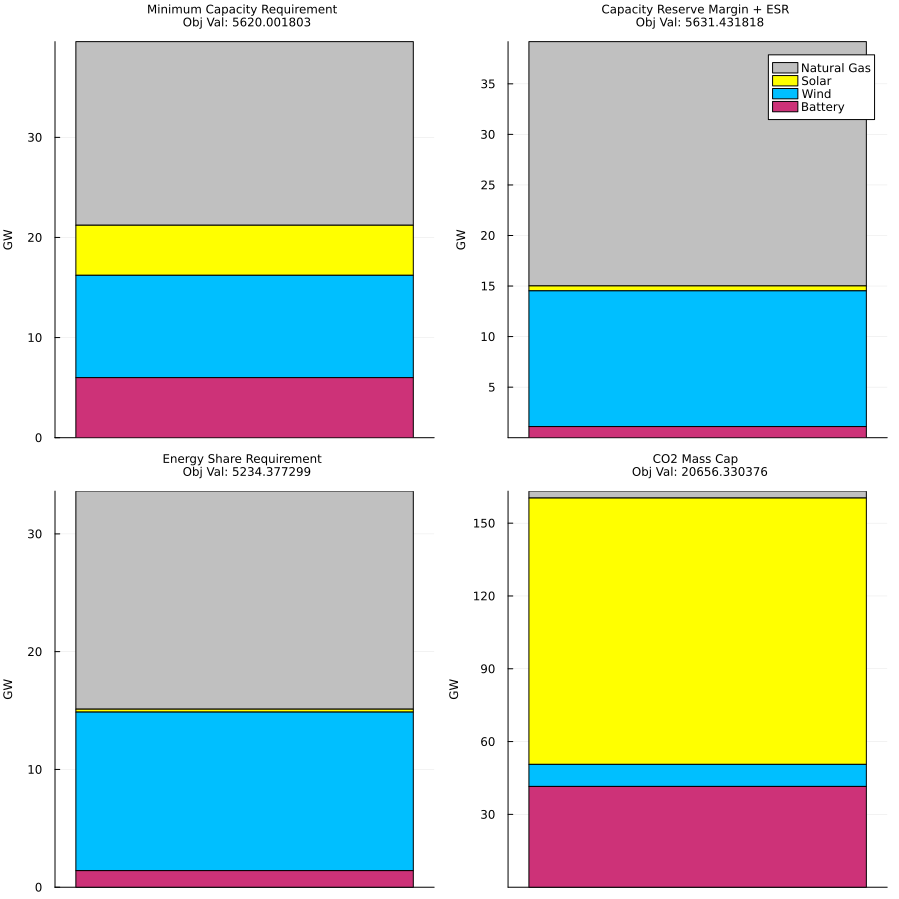

In [59]:
totCap9 = value.(EP9[:eTotalCap])

totCapB9 = [totCap9[1] + totCap9[3] + totCap9[6], totCap9[2] + totCap9[5], 
    totCap9[4] + totCap9[7], totCap9[8] + totCap9[9] + totCap9[10]]

println(DataFrame([RT totCap9],["Resource Type","Total Capacity"]))
println(" ")

G9 = groupedbar(transpose(totCapB9), bar_position = :stack, bar_width=.7,size=(500,450), xticks=[ ],ylabel="GW",
        labels=["Natural Gas" "Solar" "Wind" "Battery"],legend=false,color=colors,
        title="Minimum Capacity Requirement \n Obj Val: $(round(objective_value(EP9),digits=6))",ylabelfontsize=8)

plot(G9,G8,G7,G2,size=(900,900), titlefontsize=8,layout=(2,2))

## All Together <a id="All"></a>

`SmallNewEngland/ThreeZones` has defaults of `CO2Cap = 2` and `MinCapReq = 1`. To see how everything comes together, let's add ESR and CRM in as well:

In [61]:
setup["MinCapReq"] = 1
setup["CO2Cap"] = 2
setup["EnergyShareRequirement"] = 1
setup["CapacityReserveMargin"] = 1;

2

In [66]:
inputs = GenX.load_inputs(setup, case)
EP10 = GenX.generate_model(setup,inputs,OPTIMIZER)
GenX.solve_model(EP10,setup)

Reading Input CSV Files
Network.csv Successfully Read!
Load_data.csv Successfully Read!
Fuels_data.csv Successfully Read!
Generators_data.csv Successfully Read!
Generators_variability.csv Successfully Read!
Validating time basis
Minimum_capacity_requirement.csv Successfully Read!
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From Example_Systems_Tutorials/SmallNewEngland/ThreeZones
Discharge Module
Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Emissions Module (for CO2 Policy modularization
Transmission Module
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
C02 Policies Module
Minimum Capacity Requirement Module
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
123660 rows, 81159 cols, 478145 nonzeros
116560 rows, 74061 cols, 478425 no

(A JuMP Model
Minimization problem with:
Variables: 83192
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 24024 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 20334 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 103509 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 4 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 79492 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: cCO2Emissions_systemwide, cMaxCap, cMaxCapEnergy, cMaxCapEnergyDuration, cMaxFlow_in, cMaxFlow_out, cMaxLineReinforcement, cMaxNSE, cMaxRetCommit, cMaxRetEnergy, cMaxRetNoCommit, cMinCap, cMinCapEnergy, cMinCapEnergyDuration, cNSEPerSeg, cPowerBalance, cSoCBalInterior, cSoCBalStart, cTAuxLimit, cTAuxSum, cTLoss, cZoneMinCapReq, eAvail_Trans_Cap, eCFix, eCFixEnergy, eCNSE, eCStart, eCVar_in, eCVar_out, eELOSS, eELOSSByZone, eEmissionsByP

10×2 DataFrame
 Row │ Resource Type                     Total Capacity 
     │ Any                               Any            
─────┼──────────────────────────────────────────────────
   1 │ natural_gas_fired_combined_cycle  8.53057
   2 │ solar_photovoltaic                14.1856
   3 │ natural_gas_fired_combined_cycle  2.12054
   4 │ onshore_wind_turbine              15.5912
   5 │ solar_photovoltaic                13.4406
   6 │ natural_gas_fired_combined_cycle  0.546416
   7 │ onshore_wind_turbine              10.6662
   8 │ battery_mid                       2.19461
   9 │ battery_mid                       5.35606
  10 │ battery_mid                       1.83847
 


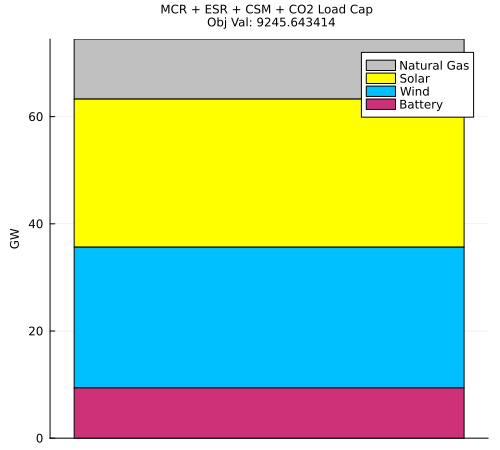

In [79]:
totCap10 = value.(EP10[:eTotalCap])

totCapB10 = [totCap10[1] + totCap10[3] + totCap10[6], totCap10[2] + totCap10[5], 
    totCap10[4] + totCap10[7], totCap10[8] + totCap10[9] + totCap10[10]]

println(DataFrame([RT totCap10],["Resource Type","Total Capacity"]))
println(" ")

G10 = groupedbar(transpose(totCapB10), bar_position = :stack, bar_width=.7,size=(500,450), xticks=[ ],ylabel="GW",
        labels=["Natural Gas" "Solar" "Wind" "Battery"],color=colors,
        title="MCR + ESR + CSM + CO2 Load Cap \n Obj Val: $(round(objective_value(EP10),digits=6))",ylabelfontsize=8)

plot(G10, titlefontsize=8)